# Import Libraries

In [1]:
import argparse
import math
import os
import os.path as ops
import time

import cv2
import glog as log
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# ignore warning for tf 2.0
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(tf.__version__)

1.13.0-rc2


# Setting Data Set and Weights Path

In [4]:
dataset_dir = 'data/training_data_tusimple_gamma_tusimple_0d4/'
weights_path = 'model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000'

# Setting parameters

In [5]:
__C = edict()

cfg = __C

__C.TRAIN = edict()
__C.TRAIN.EPOCHS = 5000
__C.TRAIN.NOOFBATCHES = 10
__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.LEARNING_RATE = 0.0005
__C.TRAIN.GPU_MEMORY_FRACTION = 0.85
__C.TRAIN.TF_ALLOW_GROWTH = True
__C.TRAIN.BATCH_SIZE = 8
__C.TRAIN.IMG_HEIGHT = 256
__C.TRAIN.IMG_WIDTH = 512

# Reading Data Set

In [6]:
class DataSet(object):
    def __init__(self, dataset_info_file):
        self._gt_img_list, self._gt_label_binary_list = self._init_dataset(dataset_info_file)
        self._random_dataset()
        self._next_batch_loop_count = 0

    def _init_dataset(self, dataset_info_file):
        gt_img_list = []
        gt_label_binary_list = []

        assert ops.exists(dataset_info_file), '{:s}　does not exist'.format(dataset_info_file)

        with open(dataset_info_file, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                gt_img_list.append(info_tmp[0])
                gt_label_binary_list.append(info_tmp[1])

        return gt_img_list, gt_label_binary_list

    def _random_dataset(self):
        assert len(self._gt_img_list) == len(self._gt_label_binary_list)

        random_idx = np.random.permutation(len(self._gt_img_list))
        new_gt_img_list = []
        new_gt_label_binary_list = []

        for index in random_idx:
            new_gt_img_list.append(self._gt_img_list[index])
            new_gt_label_binary_list.append(self._gt_label_binary_list[index])

        self._gt_img_list = new_gt_img_list
        self._gt_label_binary_list = new_gt_label_binary_list

    def next_batch(self, batch_size):
        assert len(self._gt_label_binary_list) == len(self._gt_img_list)

        idx_start = batch_size * self._next_batch_loop_count
        idx_end = batch_size * self._next_batch_loop_count + batch_size

        if idx_start == 0 and idx_end > len(self._gt_label_binary_list):
            raise ValueError('Batch size cannot be larger than the total number of samples', 
                             idx_end, len(self._gt_label_binary_list))

        if idx_end > len(self._gt_label_binary_list):
            self._random_dataset()
            self._next_batch_loop_count = 0
            return self.next_batch(batch_size)
        else:
            gt_img_list = self._gt_img_list[idx_start:idx_end]
            gt_label_binary_list = self._gt_label_binary_list[idx_start:idx_end]

            gt_imgs = []
            gt_labels_binary = []

            for gt_img_path in gt_img_list:
                gt_imgs.append(cv2.imread(gt_img_path, cv2.IMREAD_COLOR))

            for gt_label_path in gt_label_binary_list:
                label_img = cv2.imread(gt_label_path, cv2.IMREAD_COLOR)
                label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
                idx = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
                label_binary[idx] = 1
                gt_labels_binary.append(label_binary)

            self._next_batch_loop_count += 1

        return gt_imgs, gt_labels_binary

In [7]:
# train dataset
train_dataset_file = ops.join(dataset_dir, 'train.txt')
assert ops.exists(train_dataset_file)
train_dataset = DataSet(train_dataset_file)

# CNN Base Function
## cnn_basenet.py

In [8]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [in_channel / split, out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [in_channel / split, out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format) if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, \
                   padding='VALID', data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(value=inputdata, ksize=kernel, strides=strides, \
                              padding=padding, data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)
        return ret

# Defining model using conv2d, Relu and Maxpooling

## fcn_decoder.py

In [9]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [10]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [11]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def _build_model(self, input_tensor, name):
        with tf.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')
            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def compute_loss(self, input_tensor, binary_label, name):
        with tf.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')

            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_label_plain = tf.reshape(binary_label,
                                            shape=[binary_label.get_shape().as_list()[0] *
                                                   binary_label.get_shape().as_list()[1] *
                                                   binary_label.get_shape().as_list()[2]])
            # Add class weights
            unique_labels, unique_id, counts = tf.unique_with_counts(binary_label_plain)
            counts = tf.cast(counts, tf.float32)
            inverse_weights = tf.divide(1.0,
                                        tf.log(tf.add(tf.divide(tf.constant(1.0), counts),
                                                      tf.constant(1.02))))
            inverse_weights = tf.gather(inverse_weights, binary_label)
            binary_segmenatation_loss = tf.losses.sparse_softmax_cross_entropy(labels=binary_label, \
                                                                               logits=decode_logits, \
                                                                               weights=inverse_weights)
            binary_segmenatation_loss = tf.reduce_mean(binary_segmenatation_loss)

            ret = {'loss': binary_segmenatation_loss, 'binary_seg_logits': decode_logits}

            return ret

# Define cost, optimizer and accuracy

In [12]:
CFG = cfg

In [13]:
with tf.device('/gpu:0'):
    input_tensor = tf.placeholder(dtype=tf.float32,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 3],
                                  name='input_tensor')
    binary_label = tf.placeholder(dtype=tf.int64,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 1],
                                         name='binary_label')

    # Create the model
    phase = tf.placeholder(dtype=tf.string, shape=None, name='net_phase')
    net = LaneNet(phase=phase)

    # Define loss
    compute_ret = net.compute_loss(input_tensor=input_tensor, binary_label=binary_label, name='lanenet_model')
    loss = compute_ret['loss']

    # Evaluate model
    out_logits = compute_ret['binary_seg_logits']
    out_logits = tf.nn.softmax(logits=out_logits)
    out_logits_out = tf.argmax(out_logits, axis=-1)
    out = tf.argmax(out_logits, axis=-1)
    out = tf.expand_dims(out, axis=-1)

    idx = tf.where(tf.equal(binary_label, 1))
    pix_cls_ret = tf.gather_nd(out, idx)
    accuracy = tf.count_nonzero(pix_cls_ret)
    accuracy = tf.divide(accuracy, tf.cast(tf.shape(pix_cls_ret)[0], tf.int64))

    # Define optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(CFG.TRAIN.LEARNING_RATE, global_step,
                                               100000, 0.1, staircase=True)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, \
                                               momentum=CFG.TRAIN.MOMENTUM).minimize(loss=loss,
                                                                                     var_list=tf.trainable_variables(),
                                                                                     global_step=global_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Set a session

In [14]:
# Set sess configuration
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=sess_config)

In [15]:
# Set tf saver
model_save_dir = 'model/tusimple_lanenet'
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)

train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = 'tusimple_lanenet_{:s}.ckpt'.format(str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

saver = tf.train.Saver()

tf.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                     name='{:s}/lanenet_model.pb'.format(model_save_dir))

'model/tusimple_lanenet/lanenet_model.pb'

In [16]:
# Set tf summary
tboard_save_path = 'tboard/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(tboard_save_path):
    os.makedirs(tboard_save_path)

train_accuracy_scalar = tf.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_scalar = tf.summary.scalar(name='train_loss', tensor=loss)
learning_rate_scalar = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
merged_summary_op = tf.summary.merge([train_accuracy_scalar, train_loss_scalar, learning_rate_scalar])

summary_writer = tf.summary.FileWriter(tboard_save_path)
summary_writer.add_graph(sess.graph)

In [17]:
# Set output image folder
image_save_path = 'data_ret/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(image_save_path):
    os.makedirs(image_save_path)

# Running the session

In [18]:
VGG_MEAN = [103.939, 116.779, 123.68]

history = []
train_cost_time_mean = []

In [19]:
def resize_training_data(gt_imgs, binary_gt_labels):
    gt_imgs = [cv2.resize(tmp,
                          dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                          dst=tmp,
                          interpolation=cv2.INTER_LINEAR)
               for tmp in gt_imgs]
    gt_imgs = [tmp - VGG_MEAN for tmp in gt_imgs]

    binary_gt_labels = [cv2.resize(tmp,
                                   dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                                   dst=tmp,
                                   interpolation=cv2.INTER_NEAREST)
                        for tmp in binary_gt_labels]
    binary_gt_labels = [np.expand_dims(tmp, axis=-1) for tmp in binary_gt_labels]
    
    return gt_imgs, binary_gt_labels

In [20]:
with sess.as_default():
    # sess init or restore
    if weights_path is None:
        log.info('Training from scratch')
        init = tf.global_variables_initializer()
        sess.run(init)

        # read vgg model
        pretrained_weights = np.load('./data/vgg16.npy', encoding='latin1').item()
        for vv in tf.trainable_variables():
            weights_key = vv.name.split('/')[-3]
            try:
                weights = pretrained_weights[weights_key][0]
                _op = tf.assign(vv, weights)
                sess.run(_op)
            except Exception as e:
                continue
    else:
        log.info('Restore model from last model checkpoint {:s}'.format(weights_path))
        # restore weights
        saver.restore(sess=sess, save_path=weights_path)

    # epoch loop
    for epoch in range(CFG.TRAIN.EPOCHS):

        # Use training data for optimization
        for _ in range(CFG.TRAIN.NOOFBATCHES):
            with tf.device('/cpu:0'):
                gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
                gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

            sess.run(optimizer, feed_dict={input_tensor:gt_imgs, 
                                           binary_label:binary_gt_labels, 
                                           phase:'train'})

        # Validate after every epoch
        t_start = time.time()
        with tf.device('/cpu:0'):
            gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        train_loss, train_accuracy, train_img, train_summary = \
            sess.run([loss, accuracy, out_logits_out, merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'train'})

        # time
        cost_time = time.time() - t_start
        train_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=train_summary, global_step=epoch)

        # history
        if epoch*CFG.TRAIN.NOOFBATCHES > 10:
            history.append([train_loss, train_accuracy])

        # progress
        if epoch*CFG.TRAIN.NOOFBATCHES % 10 == 0:
            print('Epoch: {:6d} loss= {:6f} acc= {:6f} cost_time= {:5f}s '.
                  format(epoch, train_loss, train_accuracy, np.mean(train_cost_time_mean)))
            train_cost_time_mean.clear()

        # output image
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            binary_seg_image_3ch = np.array([[[0]*3]*__C.TRAIN.IMG_WIDTH]*__C.TRAIN.IMG_HEIGHT, np.float64)
            binary_seg_image_3ch[:, :, 0] = 0
            binary_seg_image_3ch[:, :, 1] = 0
            binary_seg_image_3ch[:, :, 2] = train_img[0][:, :]*255
            image = gt_imgs[0] + VGG_MEAN
            image_field2 = cv2.addWeighted(image, 1.0, binary_seg_image_3ch, 1.0, 0.0)
            path = image_save_path + '/image_{:d}.png'.format(epoch)
            cv2.imwrite(path, image_field2)

        # store model
        if epoch*CFG.TRAIN.NOOFBATCHES % 2000 == 0:
            saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

sess.close()

I0326 23:07:27.180421 21590 <ipython-input-20-53846b8186df>:19] Restore model from last model checkpoint model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000


Epoch:      0 loss= 7.244865 acc= 0.711662 cost_time= 0.495296s 
Epoch:      1 loss= 3.435430 acc= 0.810470 cost_time= 0.337900s 
Epoch:      2 loss= 8.279784 acc= 0.701485 cost_time= 0.341886s 
Epoch:      3 loss= 5.730187 acc= 0.796917 cost_time= 0.317106s 
Epoch:      4 loss= 3.868070 acc= 0.808751 cost_time= 0.328688s 
Epoch:      5 loss= 4.734693 acc= 0.789500 cost_time= 0.319542s 
Epoch:      6 loss= 4.079753 acc= 0.824186 cost_time= 0.314499s 
Epoch:      7 loss= 6.760619 acc= 0.766607 cost_time= 0.310062s 
Epoch:      8 loss= 4.865343 acc= 0.798995 cost_time= 0.317200s 
Epoch:      9 loss= 2.038992 acc= 0.887292 cost_time= 0.330010s 
Epoch:     10 loss= 3.500103 acc= 0.852683 cost_time= 0.348159s 
Epoch:     11 loss= 2.915204 acc= 0.845604 cost_time= 0.336218s 
Epoch:     12 loss= 2.248005 acc= 0.889508 cost_time= 0.332469s 
Epoch:     13 loss= 4.070166 acc= 0.837687 cost_time= 0.327591s 
Epoch:     14 loss= 3.769880 acc= 0.800279 cost_time= 0.326402s 
Epoch:     15 loss= 2.916

Epoch:    127 loss= 1.548185 acc= 0.847327 cost_time= 0.333641s 
Epoch:    128 loss= 3.455930 acc= 0.846435 cost_time= 0.334569s 
Epoch:    129 loss= 2.594547 acc= 0.800969 cost_time= 0.327717s 
Epoch:    130 loss= 0.870565 acc= 0.904355 cost_time= 0.345766s 
Epoch:    131 loss= 0.836028 acc= 0.924582 cost_time= 0.352250s 
Epoch:    132 loss= 0.670532 acc= 0.932504 cost_time= 0.423507s 
Epoch:    133 loss= 0.965804 acc= 0.879867 cost_time= 0.348984s 
Epoch:    134 loss= 0.675763 acc= 0.916180 cost_time= 0.342553s 
Epoch:    135 loss= 0.691370 acc= 0.933425 cost_time= 0.354347s 
Epoch:    136 loss= 3.022183 acc= 0.847532 cost_time= 0.344814s 
Epoch:    137 loss= 2.517225 acc= 0.861451 cost_time= 0.345534s 
Epoch:    138 loss= 1.020048 acc= 0.898143 cost_time= 0.320245s 
Epoch:    139 loss= 0.686199 acc= 0.923621 cost_time= 0.345542s 
Epoch:    140 loss= 2.390042 acc= 0.795956 cost_time= 0.331258s 
Epoch:    141 loss= 1.036168 acc= 0.898381 cost_time= 0.331115s 
Epoch:    142 loss= 1.154

Epoch:    254 loss= 0.770810 acc= 0.928541 cost_time= 0.317345s 
Epoch:    255 loss= 0.752931 acc= 0.908700 cost_time= 0.331206s 
Epoch:    256 loss= 0.629886 acc= 0.936740 cost_time= 0.318940s 
Epoch:    257 loss= 0.779341 acc= 0.915622 cost_time= 0.319631s 
Epoch:    258 loss= 0.491283 acc= 0.938112 cost_time= 0.323834s 
Epoch:    259 loss= 1.788641 acc= 0.797589 cost_time= 0.331386s 
Epoch:    260 loss= 2.153614 acc= 0.803107 cost_time= 0.310445s 
Epoch:    261 loss= 2.905858 acc= 0.854816 cost_time= 0.316370s 
Epoch:    262 loss= 0.922777 acc= 0.896348 cost_time= 0.323247s 
Epoch:    263 loss= 2.613820 acc= 0.832768 cost_time= 0.314975s 
Epoch:    264 loss= 3.943381 acc= 0.822780 cost_time= 0.319832s 
Epoch:    265 loss= 1.125989 acc= 0.857326 cost_time= 0.315120s 
Epoch:    266 loss= 0.774866 acc= 0.911787 cost_time= 0.313447s 
Epoch:    267 loss= 2.928788 acc= 0.847493 cost_time= 0.314289s 
Epoch:    268 loss= 0.726219 acc= 0.918883 cost_time= 0.319734s 
Epoch:    269 loss= 0.951

Epoch:    381 loss= 0.711479 acc= 0.915887 cost_time= 0.313633s 
Epoch:    382 loss= 1.478314 acc= 0.808256 cost_time= 0.317727s 
Epoch:    383 loss= 0.996363 acc= 0.910704 cost_time= 0.322428s 
Epoch:    384 loss= 2.092217 acc= 0.864803 cost_time= 0.321554s 
Epoch:    385 loss= 2.028803 acc= 0.825239 cost_time= 0.323401s 
Epoch:    386 loss= 0.676561 acc= 0.928548 cost_time= 0.320855s 
Epoch:    387 loss= 2.408459 acc= 0.874400 cost_time= 0.330594s 
Epoch:    388 loss= 0.501579 acc= 0.930644 cost_time= 0.313727s 
Epoch:    389 loss= 0.752375 acc= 0.904976 cost_time= 0.322467s 
Epoch:    390 loss= 0.595475 acc= 0.931212 cost_time= 0.318672s 
Epoch:    391 loss= 1.236553 acc= 0.817175 cost_time= 0.326644s 
Epoch:    392 loss= 1.067248 acc= 0.862743 cost_time= 0.315019s 
Epoch:    393 loss= 0.776775 acc= 0.920914 cost_time= 0.319281s 
Epoch:    394 loss= 0.756397 acc= 0.910844 cost_time= 0.336264s 
Epoch:    395 loss= 0.492711 acc= 0.927291 cost_time= 0.322481s 
Epoch:    396 loss= 0.573

Epoch:    508 loss= 1.192156 acc= 0.859538 cost_time= 0.339851s 
Epoch:    509 loss= 0.582374 acc= 0.921959 cost_time= 0.342895s 
Epoch:    510 loss= 0.675743 acc= 0.924072 cost_time= 0.356995s 
Epoch:    511 loss= 0.719290 acc= 0.889512 cost_time= 0.366997s 
Epoch:    512 loss= 0.457220 acc= 0.933863 cost_time= 0.345175s 
Epoch:    513 loss= 2.283716 acc= 0.867856 cost_time= 0.327660s 
Epoch:    514 loss= 2.836793 acc= 0.871801 cost_time= 0.349924s 
Epoch:    515 loss= 2.074419 acc= 0.837878 cost_time= 0.344641s 
Epoch:    516 loss= 0.398440 acc= 0.946797 cost_time= 0.352882s 
Epoch:    517 loss= 0.507244 acc= 0.925383 cost_time= 0.347996s 
Epoch:    518 loss= 1.167444 acc= 0.884477 cost_time= 0.343573s 
Epoch:    519 loss= 0.476327 acc= 0.939376 cost_time= 0.336756s 
Epoch:    520 loss= 0.510367 acc= 0.944070 cost_time= 0.334517s 
Epoch:    521 loss= 0.478771 acc= 0.920007 cost_time= 0.342205s 
Epoch:    522 loss= 0.532008 acc= 0.917446 cost_time= 0.334393s 
Epoch:    523 loss= 0.384

Epoch:    635 loss= 3.418358 acc= 0.822488 cost_time= 0.328801s 
Epoch:    636 loss= 0.567646 acc= 0.925311 cost_time= 0.327011s 
Epoch:    637 loss= 1.113852 acc= 0.884354 cost_time= 0.322716s 
Epoch:    638 loss= 0.438382 acc= 0.930388 cost_time= 0.323035s 
Epoch:    639 loss= 3.403479 acc= 0.787042 cost_time= 0.324431s 
Epoch:    640 loss= 0.583611 acc= 0.913576 cost_time= 0.325104s 
Epoch:    641 loss= 2.399956 acc= 0.873945 cost_time= 0.323270s 
Epoch:    642 loss= 0.986293 acc= 0.870280 cost_time= 0.319840s 
Epoch:    643 loss= 0.437636 acc= 0.941122 cost_time= 0.325385s 
Epoch:    644 loss= 0.677023 acc= 0.891568 cost_time= 0.320199s 
Epoch:    645 loss= 0.640502 acc= 0.921253 cost_time= 0.320931s 
Epoch:    646 loss= 1.739289 acc= 0.876143 cost_time= 0.329004s 
Epoch:    647 loss= 0.535809 acc= 0.936460 cost_time= 0.322855s 
Epoch:    648 loss= 0.684515 acc= 0.908201 cost_time= 0.322230s 
Epoch:    649 loss= 0.651166 acc= 0.904940 cost_time= 0.320046s 
Epoch:    650 loss= 0.684

Epoch:    762 loss= 0.439095 acc= 0.917759 cost_time= 0.313304s 
Epoch:    763 loss= 0.363961 acc= 0.932985 cost_time= 0.315171s 
Epoch:    764 loss= 0.399126 acc= 0.936637 cost_time= 0.311791s 
Epoch:    765 loss= 0.825977 acc= 0.841729 cost_time= 0.305604s 
Epoch:    766 loss= 0.790434 acc= 0.864137 cost_time= 0.308272s 
Epoch:    767 loss= 0.753010 acc= 0.889291 cost_time= 0.304032s 
Epoch:    768 loss= 0.453505 acc= 0.923445 cost_time= 0.311710s 
Epoch:    769 loss= 0.428339 acc= 0.934337 cost_time= 0.314677s 
Epoch:    770 loss= 0.398307 acc= 0.942254 cost_time= 0.311563s 
Epoch:    771 loss= 1.353033 acc= 0.867254 cost_time= 0.311290s 
Epoch:    772 loss= 0.671106 acc= 0.908021 cost_time= 0.306578s 
Epoch:    773 loss= 0.620161 acc= 0.892500 cost_time= 0.311486s 
Epoch:    774 loss= 0.575798 acc= 0.923940 cost_time= 0.312119s 
Epoch:    775 loss= 0.545362 acc= 0.928288 cost_time= 0.313143s 
Epoch:    776 loss= 0.581610 acc= 0.901925 cost_time= 0.316680s 
Epoch:    777 loss= 0.576

Epoch:    889 loss= 0.777718 acc= 0.906265 cost_time= 0.308703s 
Epoch:    890 loss= 0.428737 acc= 0.932996 cost_time= 0.318206s 
Epoch:    891 loss= 0.476347 acc= 0.929876 cost_time= 0.315406s 
Epoch:    892 loss= 1.464656 acc= 0.876491 cost_time= 0.309883s 
Epoch:    893 loss= 0.446885 acc= 0.923892 cost_time= 0.312603s 
Epoch:    894 loss= 0.730698 acc= 0.874382 cost_time= 0.312415s 
Epoch:    895 loss= 0.827833 acc= 0.907567 cost_time= 0.315597s 
Epoch:    896 loss= 2.715756 acc= 0.816229 cost_time= 0.310653s 
Epoch:    897 loss= 0.452458 acc= 0.925124 cost_time= 0.313796s 
Epoch:    898 loss= 0.490925 acc= 0.902558 cost_time= 0.312365s 
Epoch:    899 loss= 1.828356 acc= 0.881143 cost_time= 0.319195s 
Epoch:    900 loss= 0.679270 acc= 0.901800 cost_time= 0.313342s 
Epoch:    901 loss= 0.492119 acc= 0.937609 cost_time= 0.312699s 
Epoch:    902 loss= 0.656299 acc= 0.878725 cost_time= 0.311913s 
Epoch:    903 loss= 0.917139 acc= 0.877809 cost_time= 0.315894s 
Epoch:    904 loss= 0.512

Epoch:   1016 loss= 0.741678 acc= 0.865431 cost_time= 0.309530s 
Epoch:   1017 loss= 0.447149 acc= 0.925973 cost_time= 0.317708s 
Epoch:   1018 loss= 1.554861 acc= 0.911935 cost_time= 0.317461s 
Epoch:   1019 loss= 0.514910 acc= 0.902637 cost_time= 0.313387s 
Epoch:   1020 loss= 0.389001 acc= 0.920628 cost_time= 0.321985s 
Epoch:   1021 loss= 0.416093 acc= 0.933675 cost_time= 0.330817s 
Epoch:   1022 loss= 1.653154 acc= 0.879352 cost_time= 0.341419s 
Epoch:   1023 loss= 0.343289 acc= 0.942447 cost_time= 0.334842s 
Epoch:   1024 loss= 0.509372 acc= 0.922158 cost_time= 0.342720s 
Epoch:   1025 loss= 0.662827 acc= 0.886937 cost_time= 0.354825s 
Epoch:   1026 loss= 0.531321 acc= 0.915424 cost_time= 0.316281s 
Epoch:   1027 loss= 0.420269 acc= 0.933765 cost_time= 0.314874s 
Epoch:   1028 loss= 0.646024 acc= 0.893591 cost_time= 0.314716s 
Epoch:   1029 loss= 1.278349 acc= 0.866172 cost_time= 0.335022s 
Epoch:   1030 loss= 0.375600 acc= 0.923562 cost_time= 0.313472s 
Epoch:   1031 loss= 0.434

Epoch:   1143 loss= 0.694902 acc= 0.923941 cost_time= 0.314202s 
Epoch:   1144 loss= 0.511227 acc= 0.912119 cost_time= 0.314307s 
Epoch:   1145 loss= 0.479306 acc= 0.917673 cost_time= 0.316084s 
Epoch:   1146 loss= 0.512837 acc= 0.916509 cost_time= 0.315766s 
Epoch:   1147 loss= 0.481934 acc= 0.916035 cost_time= 0.317492s 
Epoch:   1148 loss= 0.384690 acc= 0.922426 cost_time= 0.313536s 
Epoch:   1149 loss= 0.765773 acc= 0.854145 cost_time= 0.313199s 
Epoch:   1150 loss= 0.349428 acc= 0.949478 cost_time= 0.326962s 
Epoch:   1151 loss= 0.470970 acc= 0.921198 cost_time= 0.316776s 
Epoch:   1152 loss= 0.972174 acc= 0.830253 cost_time= 0.311930s 
Epoch:   1153 loss= 0.651774 acc= 0.872474 cost_time= 0.311943s 
Epoch:   1154 loss= 0.755281 acc= 0.846090 cost_time= 0.306494s 
Epoch:   1155 loss= 0.453133 acc= 0.932783 cost_time= 0.329066s 
Epoch:   1156 loss= 0.457030 acc= 0.915065 cost_time= 0.313860s 
Epoch:   1157 loss= 1.164587 acc= 0.877078 cost_time= 0.311793s 
Epoch:   1158 loss= 0.562

Epoch:   1270 loss= 0.377593 acc= 0.933074 cost_time= 0.316686s 
Epoch:   1271 loss= 0.449224 acc= 0.925427 cost_time= 0.311882s 
Epoch:   1272 loss= 0.534691 acc= 0.912717 cost_time= 0.316350s 
Epoch:   1273 loss= 0.511731 acc= 0.913582 cost_time= 0.312009s 
Epoch:   1274 loss= 0.314021 acc= 0.929151 cost_time= 0.314065s 
Epoch:   1275 loss= 1.285351 acc= 0.892853 cost_time= 0.313699s 
Epoch:   1276 loss= 0.756632 acc= 0.903346 cost_time= 0.312942s 
Epoch:   1277 loss= 0.365632 acc= 0.940249 cost_time= 0.310416s 
Epoch:   1278 loss= 0.710912 acc= 0.908567 cost_time= 0.315776s 
Epoch:   1279 loss= 0.878456 acc= 0.903484 cost_time= 0.319109s 
Epoch:   1280 loss= 0.364419 acc= 0.938312 cost_time= 0.319351s 
Epoch:   1281 loss= 0.949256 acc= 0.829438 cost_time= 0.312215s 
Epoch:   1282 loss= 0.557474 acc= 0.899517 cost_time= 0.313478s 
Epoch:   1283 loss= 0.368643 acc= 0.933497 cost_time= 0.317346s 
Epoch:   1284 loss= 0.564690 acc= 0.894710 cost_time= 0.326214s 
Epoch:   1285 loss= 0.545

Epoch:   1397 loss= 0.446251 acc= 0.937735 cost_time= 0.329772s 
Epoch:   1398 loss= 0.811767 acc= 0.914601 cost_time= 0.324798s 
Epoch:   1399 loss= 0.526138 acc= 0.923987 cost_time= 0.313765s 
Epoch:   1400 loss= 0.414254 acc= 0.932632 cost_time= 0.332309s 
Epoch:   1401 loss= 0.354174 acc= 0.947096 cost_time= 0.321037s 
Epoch:   1402 loss= 0.305900 acc= 0.929307 cost_time= 0.340316s 
Epoch:   1403 loss= 0.944165 acc= 0.858685 cost_time= 0.309160s 
Epoch:   1404 loss= 0.360222 acc= 0.947573 cost_time= 0.315889s 
Epoch:   1405 loss= 0.818729 acc= 0.861710 cost_time= 0.319000s 
Epoch:   1406 loss= 0.389369 acc= 0.928314 cost_time= 0.313327s 
Epoch:   1407 loss= 0.479172 acc= 0.914956 cost_time= 0.338251s 
Epoch:   1408 loss= 0.617043 acc= 0.912802 cost_time= 0.310989s 
Epoch:   1409 loss= 0.374614 acc= 0.938722 cost_time= 0.332721s 
Epoch:   1410 loss= 0.824291 acc= 0.857584 cost_time= 0.308599s 
Epoch:   1411 loss= 0.594589 acc= 0.905180 cost_time= 0.332510s 
Epoch:   1412 loss= 0.540

Epoch:   1524 loss= 0.380515 acc= 0.920517 cost_time= 0.327899s 
Epoch:   1525 loss= 0.639982 acc= 0.916033 cost_time= 0.317026s 
Epoch:   1526 loss= 1.699812 acc= 0.846261 cost_time= 0.309283s 
Epoch:   1527 loss= 1.152647 acc= 0.861956 cost_time= 0.310377s 
Epoch:   1528 loss= 0.297835 acc= 0.939342 cost_time= 0.314626s 
Epoch:   1529 loss= 0.342696 acc= 0.940177 cost_time= 0.336726s 
Epoch:   1530 loss= 0.475696 acc= 0.902999 cost_time= 0.308178s 
Epoch:   1531 loss= 0.376864 acc= 0.927767 cost_time= 0.312448s 
Epoch:   1532 loss= 0.443975 acc= 0.930349 cost_time= 0.310054s 
Epoch:   1533 loss= 1.074018 acc= 0.907989 cost_time= 0.311844s 
Epoch:   1534 loss= 0.361944 acc= 0.947238 cost_time= 0.312811s 
Epoch:   1535 loss= 0.386056 acc= 0.923537 cost_time= 0.307103s 
Epoch:   1536 loss= 0.599053 acc= 0.908286 cost_time= 0.306596s 
Epoch:   1537 loss= 0.408736 acc= 0.926749 cost_time= 0.312269s 
Epoch:   1538 loss= 0.342644 acc= 0.949091 cost_time= 0.318398s 
Epoch:   1539 loss= 0.597

Epoch:   1651 loss= 0.275826 acc= 0.955791 cost_time= 0.311330s 
Epoch:   1652 loss= 1.219650 acc= 0.797341 cost_time= 0.315255s 
Epoch:   1653 loss= 1.267321 acc= 0.860976 cost_time= 0.307387s 
Epoch:   1654 loss= 0.297467 acc= 0.949992 cost_time= 0.314949s 
Epoch:   1655 loss= 0.323873 acc= 0.941860 cost_time= 0.313271s 
Epoch:   1656 loss= 0.269484 acc= 0.930830 cost_time= 0.311485s 
Epoch:   1657 loss= 0.324392 acc= 0.929490 cost_time= 0.331088s 
Epoch:   1658 loss= 0.509003 acc= 0.884257 cost_time= 0.308194s 
Epoch:   1659 loss= 1.165558 acc= 0.771498 cost_time= 0.306249s 
Epoch:   1660 loss= 0.336507 acc= 0.916208 cost_time= 0.304147s 
Epoch:   1661 loss= 0.403300 acc= 0.923922 cost_time= 0.312465s 
Epoch:   1662 loss= 0.355911 acc= 0.928962 cost_time= 0.312476s 
Epoch:   1663 loss= 0.776961 acc= 0.899114 cost_time= 0.306576s 
Epoch:   1664 loss= 0.349726 acc= 0.931246 cost_time= 0.329140s 
Epoch:   1665 loss= 0.258179 acc= 0.952736 cost_time= 0.313009s 
Epoch:   1666 loss= 0.477

Epoch:   1778 loss= 0.404985 acc= 0.928148 cost_time= 0.315545s 
Epoch:   1779 loss= 0.391859 acc= 0.943183 cost_time= 0.310729s 
Epoch:   1780 loss= 0.955436 acc= 0.838861 cost_time= 0.310238s 
Epoch:   1781 loss= 0.320392 acc= 0.942011 cost_time= 0.312547s 
Epoch:   1782 loss= 0.419792 acc= 0.935445 cost_time= 0.312333s 
Epoch:   1783 loss= 0.679985 acc= 0.875951 cost_time= 0.326320s 
Epoch:   1784 loss= 0.267740 acc= 0.948252 cost_time= 0.308620s 
Epoch:   1785 loss= 0.731232 acc= 0.897663 cost_time= 0.316157s 
Epoch:   1786 loss= 0.255360 acc= 0.945111 cost_time= 0.310428s 
Epoch:   1787 loss= 0.266544 acc= 0.939452 cost_time= 0.314297s 
Epoch:   1788 loss= 0.299621 acc= 0.938406 cost_time= 0.309775s 
Epoch:   1789 loss= 0.455920 acc= 0.935949 cost_time= 0.305017s 
Epoch:   1790 loss= 0.913761 acc= 0.896953 cost_time= 0.327192s 
Epoch:   1791 loss= 0.351778 acc= 0.952908 cost_time= 0.314428s 
Epoch:   1792 loss= 1.299851 acc= 0.865078 cost_time= 0.313450s 
Epoch:   1793 loss= 0.368

Epoch:   1905 loss= 0.262362 acc= 0.937550 cost_time= 0.311865s 
Epoch:   1906 loss= 0.386312 acc= 0.920599 cost_time= 0.310188s 
Epoch:   1907 loss= 0.322836 acc= 0.949053 cost_time= 0.311672s 
Epoch:   1908 loss= 0.302583 acc= 0.951065 cost_time= 0.312597s 
Epoch:   1909 loss= 0.675528 acc= 0.879441 cost_time= 0.313775s 
Epoch:   1910 loss= 0.330974 acc= 0.938854 cost_time= 0.310416s 
Epoch:   1911 loss= 0.318579 acc= 0.937411 cost_time= 0.330231s 
Epoch:   1912 loss= 0.315436 acc= 0.952397 cost_time= 0.311546s 
Epoch:   1913 loss= 1.391479 acc= 0.885445 cost_time= 0.312481s 
Epoch:   1914 loss= 0.529337 acc= 0.884153 cost_time= 0.307908s 
Epoch:   1915 loss= 0.384581 acc= 0.934940 cost_time= 0.317096s 
Epoch:   1916 loss= 0.662870 acc= 0.910082 cost_time= 0.319777s 
Epoch:   1917 loss= 0.985218 acc= 0.895316 cost_time= 0.317358s 
Epoch:   1918 loss= 0.310929 acc= 0.931536 cost_time= 0.326309s 
Epoch:   1919 loss= 0.776180 acc= 0.908846 cost_time= 0.311401s 
Epoch:   1920 loss= 0.397

Epoch:   2032 loss= 1.838826 acc= 0.791504 cost_time= 0.318444s 
Epoch:   2033 loss= 0.368722 acc= 0.918459 cost_time= 0.310042s 
Epoch:   2034 loss= 0.457561 acc= 0.904103 cost_time= 0.308137s 
Epoch:   2035 loss= 0.361611 acc= 0.930373 cost_time= 0.307745s 
Epoch:   2036 loss= 0.445433 acc= 0.922942 cost_time= 0.313669s 
Epoch:   2037 loss= 0.320742 acc= 0.942002 cost_time= 0.330194s 
Epoch:   2038 loss= 0.301434 acc= 0.940383 cost_time= 0.309630s 
Epoch:   2039 loss= 0.623973 acc= 0.853883 cost_time= 0.307280s 
Epoch:   2040 loss= 0.313762 acc= 0.944218 cost_time= 0.310159s 
Epoch:   2041 loss= 0.352421 acc= 0.940194 cost_time= 0.311085s 
Epoch:   2042 loss= 0.509606 acc= 0.924842 cost_time= 0.305890s 
Epoch:   2043 loss= 0.367941 acc= 0.923150 cost_time= 0.308719s 
Epoch:   2044 loss= 1.978778 acc= 0.829168 cost_time= 0.325824s 
Epoch:   2045 loss= 0.336068 acc= 0.932196 cost_time= 0.313542s 
Epoch:   2046 loss= 0.571074 acc= 0.886470 cost_time= 0.319413s 
Epoch:   2047 loss= 1.319

Epoch:   2159 loss= 0.632872 acc= 0.865461 cost_time= 0.305533s 
Epoch:   2160 loss= 0.451640 acc= 0.918488 cost_time= 0.311720s 
Epoch:   2161 loss= 0.287592 acc= 0.938911 cost_time= 0.319134s 
Epoch:   2162 loss= 0.499121 acc= 0.906490 cost_time= 0.308428s 
Epoch:   2163 loss= 0.907318 acc= 0.865969 cost_time= 0.305702s 
Epoch:   2164 loss= 1.405471 acc= 0.876581 cost_time= 0.309623s 
Epoch:   2165 loss= 0.835779 acc= 0.903429 cost_time= 0.313013s 
Epoch:   2166 loss= 1.433638 acc= 0.848937 cost_time= 0.314990s 
Epoch:   2167 loss= 0.314654 acc= 0.943197 cost_time= 0.317265s 
Epoch:   2168 loss= 0.647948 acc= 0.897753 cost_time= 0.306838s 
Epoch:   2169 loss= 0.226218 acc= 0.948712 cost_time= 0.311093s 
Epoch:   2170 loss= 0.678083 acc= 0.905935 cost_time= 0.331743s 
Epoch:   2171 loss= 0.598177 acc= 0.909845 cost_time= 0.314388s 
Epoch:   2172 loss= 0.770180 acc= 0.902491 cost_time= 0.321499s 
Epoch:   2173 loss= 0.475573 acc= 0.931224 cost_time= 0.315204s 
Epoch:   2174 loss= 0.531

Epoch:   2286 loss= 0.326118 acc= 0.930624 cost_time= 0.314566s 
Epoch:   2287 loss= 0.328246 acc= 0.933457 cost_time= 0.313396s 
Epoch:   2288 loss= 0.494498 acc= 0.907449 cost_time= 0.311164s 
Epoch:   2289 loss= 0.635170 acc= 0.846417 cost_time= 0.307903s 
Epoch:   2290 loss= 0.300016 acc= 0.948935 cost_time= 0.313035s 
Epoch:   2291 loss= 0.774372 acc= 0.896758 cost_time= 0.333036s 
Epoch:   2292 loss= 1.365971 acc= 0.884497 cost_time= 0.314174s 
Epoch:   2293 loss= 0.348690 acc= 0.935482 cost_time= 0.318093s 
Epoch:   2294 loss= 0.661880 acc= 0.902030 cost_time= 0.311130s 
Epoch:   2295 loss= 0.516815 acc= 0.893083 cost_time= 0.311253s 
Epoch:   2296 loss= 0.646447 acc= 0.916792 cost_time= 0.310505s 
Epoch:   2297 loss= 0.860861 acc= 0.912818 cost_time= 0.310433s 
Epoch:   2298 loss= 0.557272 acc= 0.891475 cost_time= 0.324987s 
Epoch:   2299 loss= 0.517772 acc= 0.908910 cost_time= 0.320348s 
Epoch:   2300 loss= 0.410333 acc= 0.935158 cost_time= 0.316940s 
Epoch:   2301 loss= 0.340

Epoch:   2413 loss= 0.413762 acc= 0.934954 cost_time= 0.309932s 
Epoch:   2414 loss= 2.799333 acc= 0.835923 cost_time= 0.313009s 
Epoch:   2415 loss= 0.604501 acc= 0.870053 cost_time= 0.311962s 
Epoch:   2416 loss= 0.319851 acc= 0.944281 cost_time= 0.306865s 
Epoch:   2417 loss= 1.950765 acc= 0.827171 cost_time= 0.327268s 
Epoch:   2418 loss= 0.264614 acc= 0.959622 cost_time= 0.314366s 
Epoch:   2419 loss= 1.018416 acc= 0.838619 cost_time= 0.328694s 
Epoch:   2420 loss= 0.538962 acc= 0.896154 cost_time= 0.305540s 
Epoch:   2421 loss= 1.032006 acc= 0.849884 cost_time= 0.306774s 
Epoch:   2422 loss= 0.543644 acc= 0.881734 cost_time= 0.308121s 
Epoch:   2423 loss= 0.301009 acc= 0.934450 cost_time= 0.313356s 
Epoch:   2424 loss= 0.723477 acc= 0.890597 cost_time= 0.331016s 
Epoch:   2425 loss= 0.318405 acc= 0.941778 cost_time= 0.319287s 
Epoch:   2426 loss= 0.567473 acc= 0.882693 cost_time= 0.309212s 
Epoch:   2427 loss= 0.646316 acc= 0.869057 cost_time= 0.310204s 
Epoch:   2428 loss= 0.302

Epoch:   2540 loss= 0.895410 acc= 0.900924 cost_time= 0.323385s 
Epoch:   2541 loss= 0.491021 acc= 0.888029 cost_time= 0.312754s 
Epoch:   2542 loss= 0.267415 acc= 0.952716 cost_time= 0.311526s 
Epoch:   2543 loss= 0.253370 acc= 0.952045 cost_time= 0.316893s 
Epoch:   2544 loss= 1.133401 acc= 0.865105 cost_time= 0.307333s 
Epoch:   2545 loss= 0.305054 acc= 0.943886 cost_time= 0.326698s 
Epoch:   2546 loss= 0.559464 acc= 0.861195 cost_time= 0.311712s 
Epoch:   2547 loss= 0.378142 acc= 0.922369 cost_time= 0.318705s 
Epoch:   2548 loss= 0.354187 acc= 0.931898 cost_time= 0.309062s 
Epoch:   2549 loss= 0.427789 acc= 0.898335 cost_time= 0.308566s 
Epoch:   2550 loss= 0.508882 acc= 0.883012 cost_time= 0.309135s 
Epoch:   2551 loss= 1.320666 acc= 0.851274 cost_time= 0.308520s 
Epoch:   2552 loss= 0.357160 acc= 0.933787 cost_time= 0.309825s 
Epoch:   2553 loss= 0.559782 acc= 0.880894 cost_time= 0.306448s 
Epoch:   2554 loss= 0.232230 acc= 0.944751 cost_time= 0.317143s 
Epoch:   2555 loss= 0.283

Epoch:   2667 loss= 0.310227 acc= 0.941559 cost_time= 0.312066s 
Epoch:   2668 loss= 0.550581 acc= 0.916952 cost_time= 0.314400s 
Epoch:   2669 loss= 0.245143 acc= 0.959357 cost_time= 0.310712s 
Epoch:   2670 loss= 0.286562 acc= 0.948422 cost_time= 0.306691s 
Epoch:   2671 loss= 0.979978 acc= 0.899014 cost_time= 0.326402s 
Epoch:   2672 loss= 0.320043 acc= 0.941418 cost_time= 0.310029s 
Epoch:   2673 loss= 0.275908 acc= 0.946693 cost_time= 0.308484s 
Epoch:   2674 loss= 0.352112 acc= 0.935024 cost_time= 0.313923s 
Epoch:   2675 loss= 0.387839 acc= 0.932460 cost_time= 0.315563s 
Epoch:   2676 loss= 0.418468 acc= 0.921282 cost_time= 0.329465s 
Epoch:   2677 loss= 0.570522 acc= 0.909855 cost_time= 0.311099s 
Epoch:   2678 loss= 0.310709 acc= 0.947667 cost_time= 0.311013s 
Epoch:   2679 loss= 0.256016 acc= 0.950066 cost_time= 0.312483s 
Epoch:   2680 loss= 0.297921 acc= 0.939909 cost_time= 0.314279s 
Epoch:   2681 loss= 0.570600 acc= 0.905079 cost_time= 0.307645s 
Epoch:   2682 loss= 0.706

Epoch:   2794 loss= 0.378429 acc= 0.924104 cost_time= 0.305574s 
Epoch:   2795 loss= 0.276487 acc= 0.947618 cost_time= 0.316927s 
Epoch:   2796 loss= 0.353630 acc= 0.933351 cost_time= 0.310376s 
Epoch:   2797 loss= 0.304909 acc= 0.931234 cost_time= 0.311509s 
Epoch:   2798 loss= 0.666937 acc= 0.910515 cost_time= 0.314126s 
Epoch:   2799 loss= 0.253664 acc= 0.952371 cost_time= 0.326558s 
Epoch:   2800 loss= 0.279958 acc= 0.952145 cost_time= 0.316532s 
Epoch:   2801 loss= 0.396934 acc= 0.935846 cost_time= 0.311087s 
Epoch:   2802 loss= 0.258693 acc= 0.956594 cost_time= 0.325795s 
Epoch:   2803 loss= 0.298254 acc= 0.945408 cost_time= 0.328250s 
Epoch:   2804 loss= 0.443375 acc= 0.909859 cost_time= 0.330277s 
Epoch:   2805 loss= 0.352002 acc= 0.936367 cost_time= 0.317905s 
Epoch:   2806 loss= 0.275109 acc= 0.949300 cost_time= 0.330263s 
Epoch:   2807 loss= 0.326919 acc= 0.942004 cost_time= 0.309252s 
Epoch:   2808 loss= 0.412851 acc= 0.907399 cost_time= 0.311139s 
Epoch:   2809 loss= 0.308

Epoch:   2921 loss= 0.266440 acc= 0.947228 cost_time= 0.318274s 
Epoch:   2922 loss= 1.031550 acc= 0.811671 cost_time= 0.313171s 
Epoch:   2923 loss= 0.643293 acc= 0.920632 cost_time= 0.311319s 
Epoch:   2924 loss= 0.367252 acc= 0.916314 cost_time= 0.307367s 
Epoch:   2925 loss= 0.237953 acc= 0.950125 cost_time= 0.334620s 
Epoch:   2926 loss= 0.289153 acc= 0.928470 cost_time= 0.308690s 
Epoch:   2927 loss= 0.670291 acc= 0.872836 cost_time= 0.316278s 
Epoch:   2928 loss= 0.436776 acc= 0.905610 cost_time= 0.306153s 
Epoch:   2929 loss= 0.314455 acc= 0.940463 cost_time= 0.306705s 
Epoch:   2930 loss= 0.368332 acc= 0.935540 cost_time= 0.308377s 
Epoch:   2931 loss= 0.280008 acc= 0.948247 cost_time= 0.314386s 
Epoch:   2932 loss= 0.229107 acc= 0.948799 cost_time= 0.311516s 
Epoch:   2933 loss= 0.337151 acc= 0.927258 cost_time= 0.313727s 
Epoch:   2934 loss= 0.259149 acc= 0.945055 cost_time= 0.316552s 
Epoch:   2935 loss= 0.338283 acc= 0.929802 cost_time= 0.311994s 
Epoch:   2936 loss= 0.229

Epoch:   3048 loss= 0.297514 acc= 0.941160 cost_time= 0.309772s 
Epoch:   3049 loss= 0.331662 acc= 0.933108 cost_time= 0.304802s 
Epoch:   3050 loss= 0.347323 acc= 0.920094 cost_time= 0.306309s 
Epoch:   3051 loss= 0.409077 acc= 0.913784 cost_time= 0.326977s 
Epoch:   3052 loss= 0.283567 acc= 0.942458 cost_time= 0.311298s 
Epoch:   3053 loss= 0.405525 acc= 0.932447 cost_time= 0.322751s 
Epoch:   3054 loss= 0.577553 acc= 0.869156 cost_time= 0.306552s 
Epoch:   3055 loss= 0.254926 acc= 0.949404 cost_time= 0.310034s 
Epoch:   3056 loss= 0.385256 acc= 0.928100 cost_time= 0.313675s 
Epoch:   3057 loss= 0.248906 acc= 0.944769 cost_time= 0.316560s 
Epoch:   3058 loss= 0.273567 acc= 0.934660 cost_time= 0.306778s 
Epoch:   3059 loss= 0.424497 acc= 0.909572 cost_time= 0.311434s 
Epoch:   3060 loss= 0.323204 acc= 0.930193 cost_time= 0.315118s 
Epoch:   3061 loss= 0.988655 acc= 0.907722 cost_time= 0.312680s 
Epoch:   3062 loss= 0.270535 acc= 0.949754 cost_time= 0.309941s 
Epoch:   3063 loss= 0.281

Epoch:   3175 loss= 0.382333 acc= 0.918371 cost_time= 0.328651s 
Epoch:   3176 loss= 0.950344 acc= 0.865522 cost_time= 0.303907s 
Epoch:   3177 loss= 0.303599 acc= 0.944819 cost_time= 0.308247s 
Epoch:   3178 loss= 0.383795 acc= 0.929266 cost_time= 0.308850s 
Epoch:   3179 loss= 0.403952 acc= 0.921377 cost_time= 0.306690s 
Epoch:   3180 loss= 0.928727 acc= 0.867543 cost_time= 0.328091s 
Epoch:   3181 loss= 0.289802 acc= 0.952659 cost_time= 0.311930s 
Epoch:   3182 loss= 0.302319 acc= 0.945828 cost_time= 0.307795s 
Epoch:   3183 loss= 0.344201 acc= 0.934214 cost_time= 0.306940s 
Epoch:   3184 loss= 0.292392 acc= 0.942085 cost_time= 0.333063s 
Epoch:   3185 loss= 0.885703 acc= 0.904973 cost_time= 0.307743s 
Epoch:   3186 loss= 0.394040 acc= 0.933440 cost_time= 0.312486s 
Epoch:   3187 loss= 0.199282 acc= 0.942425 cost_time= 0.311273s 
Epoch:   3188 loss= 1.447801 acc= 0.904046 cost_time= 0.310576s 
Epoch:   3189 loss= 0.564148 acc= 0.905202 cost_time= 0.311528s 
Epoch:   3190 loss= 0.253

Epoch:   3302 loss= 0.268066 acc= 0.930467 cost_time= 0.310455s 
Epoch:   3303 loss= 0.492062 acc= 0.910383 cost_time= 0.303188s 
Epoch:   3304 loss= 0.449747 acc= 0.889476 cost_time= 0.306447s 
Epoch:   3305 loss= 0.372670 acc= 0.938927 cost_time= 0.324326s 
Epoch:   3306 loss= 0.379146 acc= 0.921415 cost_time= 0.310303s 
Epoch:   3307 loss= 0.696333 acc= 0.833987 cost_time= 0.309617s 
Epoch:   3308 loss= 0.245269 acc= 0.945077 cost_time= 0.310293s 
Epoch:   3309 loss= 0.285304 acc= 0.941874 cost_time= 0.313222s 
Epoch:   3310 loss= 0.825607 acc= 0.904546 cost_time= 0.327145s 
Epoch:   3311 loss= 0.615202 acc= 0.914262 cost_time= 0.316389s 
Epoch:   3312 loss= 0.313188 acc= 0.930619 cost_time= 0.311512s 
Epoch:   3313 loss= 0.230352 acc= 0.950648 cost_time= 0.312434s 
Epoch:   3314 loss= 0.270449 acc= 0.951061 cost_time= 0.309482s 
Epoch:   3315 loss= 0.362141 acc= 0.918944 cost_time= 0.304476s 
Epoch:   3316 loss= 0.355935 acc= 0.936220 cost_time= 0.307489s 
Epoch:   3317 loss= 0.213

Epoch:   3429 loss= 0.501837 acc= 0.899435 cost_time= 0.313933s 
Epoch:   3430 loss= 0.725555 acc= 0.856961 cost_time= 0.305098s 
Epoch:   3431 loss= 0.255395 acc= 0.946239 cost_time= 0.310691s 
Epoch:   3432 loss= 0.244912 acc= 0.952003 cost_time= 0.310761s 
Epoch:   3433 loss= 0.422870 acc= 0.916389 cost_time= 0.306660s 
Epoch:   3434 loss= 0.289409 acc= 0.945920 cost_time= 0.308449s 
Epoch:   3435 loss= 0.391137 acc= 0.926907 cost_time= 0.313560s 
Epoch:   3436 loss= 0.286107 acc= 0.944229 cost_time= 0.310796s 
Epoch:   3437 loss= 0.219008 acc= 0.950461 cost_time= 0.311809s 
Epoch:   3438 loss= 1.245918 acc= 0.866192 cost_time= 0.309540s 
Epoch:   3439 loss= 0.463960 acc= 0.864218 cost_time= 0.311211s 
Epoch:   3440 loss= 1.246840 acc= 0.869711 cost_time= 0.304906s 
Epoch:   3441 loss= 0.812829 acc= 0.894708 cost_time= 0.318046s 
Epoch:   3442 loss= 0.267092 acc= 0.946253 cost_time= 0.307618s 
Epoch:   3443 loss= 0.308716 acc= 0.939290 cost_time= 0.331813s 
Epoch:   3444 loss= 0.382

Epoch:   3556 loss= 0.359705 acc= 0.932276 cost_time= 0.322630s 
Epoch:   3557 loss= 0.363378 acc= 0.921741 cost_time= 0.309780s 
Epoch:   3558 loss= 0.267378 acc= 0.937896 cost_time= 0.312238s 
Epoch:   3559 loss= 0.298386 acc= 0.939013 cost_time= 0.316359s 
Epoch:   3560 loss= 0.212272 acc= 0.954694 cost_time= 0.311175s 
Epoch:   3561 loss= 0.433935 acc= 0.910823 cost_time= 0.308505s 
Epoch:   3562 loss= 0.310164 acc= 0.953682 cost_time= 0.315104s 
Epoch:   3563 loss= 1.433589 acc= 0.903812 cost_time= 0.321978s 
Epoch:   3564 loss= 0.445368 acc= 0.912984 cost_time= 0.312419s 
Epoch:   3565 loss= 0.210210 acc= 0.962016 cost_time= 0.312850s 
Epoch:   3566 loss= 0.661812 acc= 0.882565 cost_time= 0.310524s 
Epoch:   3567 loss= 0.304087 acc= 0.929686 cost_time= 0.309401s 
Epoch:   3568 loss= 0.258653 acc= 0.950474 cost_time= 0.311463s 
Epoch:   3569 loss= 0.426093 acc= 0.921312 cost_time= 0.308917s 
Epoch:   3570 loss= 0.335599 acc= 0.924715 cost_time= 0.314518s 
Epoch:   3571 loss= 0.371

Epoch:   3683 loss= 0.201369 acc= 0.961586 cost_time= 0.313344s 
Epoch:   3684 loss= 0.254733 acc= 0.941482 cost_time= 0.318329s 
Epoch:   3685 loss= 0.233984 acc= 0.959518 cost_time= 0.315822s 
Epoch:   3686 loss= 0.543518 acc= 0.883708 cost_time= 0.309707s 
Epoch:   3687 loss= 1.212222 acc= 0.857699 cost_time= 0.307934s 
Epoch:   3688 loss= 0.361974 acc= 0.935575 cost_time= 0.310697s 
Epoch:   3689 loss= 0.258793 acc= 0.934213 cost_time= 0.333770s 
Epoch:   3690 loss= 0.267004 acc= 0.936227 cost_time= 0.312497s 
Epoch:   3691 loss= 0.264447 acc= 0.947659 cost_time= 0.312076s 
Epoch:   3692 loss= 0.180310 acc= 0.959725 cost_time= 0.316905s 
Epoch:   3693 loss= 0.223023 acc= 0.950712 cost_time= 0.316309s 
Epoch:   3694 loss= 0.289669 acc= 0.942520 cost_time= 0.310984s 
Epoch:   3695 loss= 0.286868 acc= 0.949558 cost_time= 0.307374s 
Epoch:   3696 loss= 0.280922 acc= 0.934260 cost_time= 0.331423s 
Epoch:   3697 loss= 0.334119 acc= 0.934114 cost_time= 0.310773s 
Epoch:   3698 loss= 0.557

Epoch:   3810 loss= 1.026144 acc= 0.901153 cost_time= 0.317412s 
Epoch:   3811 loss= 0.267114 acc= 0.947103 cost_time= 0.306931s 
Epoch:   3812 loss= 0.343927 acc= 0.935306 cost_time= 0.306518s 
Epoch:   3813 loss= 0.275473 acc= 0.946824 cost_time= 0.308976s 
Epoch:   3814 loss= 0.285489 acc= 0.945887 cost_time= 0.316341s 
Epoch:   3815 loss= 0.419084 acc= 0.933151 cost_time= 0.334745s 
Epoch:   3816 loss= 0.267276 acc= 0.951493 cost_time= 0.312137s 
Epoch:   3817 loss= 0.202019 acc= 0.947646 cost_time= 0.313476s 
Epoch:   3818 loss= 0.297062 acc= 0.927469 cost_time= 0.304836s 
Epoch:   3819 loss= 0.244455 acc= 0.946957 cost_time= 0.310719s 
Epoch:   3820 loss= 0.312673 acc= 0.949060 cost_time= 0.309113s 
Epoch:   3821 loss= 0.321172 acc= 0.934607 cost_time= 0.314873s 
Epoch:   3822 loss= 0.390515 acc= 0.915985 cost_time= 0.331971s 
Epoch:   3823 loss= 0.699822 acc= 0.908516 cost_time= 0.313628s 
Epoch:   3824 loss= 0.259826 acc= 0.956093 cost_time= 0.310803s 
Epoch:   3825 loss= 0.241

Epoch:   3937 loss= 0.255347 acc= 0.948136 cost_time= 0.308225s 
Epoch:   3938 loss= 0.255969 acc= 0.934808 cost_time= 0.313166s 
Epoch:   3939 loss= 0.206701 acc= 0.950607 cost_time= 0.319728s 
Epoch:   3940 loss= 0.340809 acc= 0.928974 cost_time= 0.307583s 
Epoch:   3941 loss= 0.359607 acc= 0.930617 cost_time= 0.329846s 
Epoch:   3942 loss= 0.314510 acc= 0.942315 cost_time= 0.310567s 
Epoch:   3943 loss= 0.285698 acc= 0.943678 cost_time= 0.325755s 
Epoch:   3944 loss= 0.241179 acc= 0.952983 cost_time= 0.317750s 
Epoch:   3945 loss= 0.290922 acc= 0.944508 cost_time= 0.310370s 
Epoch:   3946 loss= 0.274710 acc= 0.955213 cost_time= 0.311118s 
Epoch:   3947 loss= 0.441218 acc= 0.929704 cost_time= 0.313735s 
Epoch:   3948 loss= 0.226257 acc= 0.958994 cost_time= 0.311854s 
Epoch:   3949 loss= 0.377223 acc= 0.901272 cost_time= 0.315880s 
Epoch:   3950 loss= 0.294925 acc= 0.942169 cost_time= 0.310924s 
Epoch:   3951 loss= 0.238914 acc= 0.937691 cost_time= 0.315009s 
Epoch:   3952 loss= 0.835

Epoch:   4064 loss= 0.318642 acc= 0.923349 cost_time= 0.310332s 
Epoch:   4065 loss= 0.227604 acc= 0.951209 cost_time= 0.311746s 
Epoch:   4066 loss= 1.087332 acc= 0.881169 cost_time= 0.310578s 
Epoch:   4067 loss= 0.396404 acc= 0.926246 cost_time= 0.311627s 
Epoch:   4068 loss= 0.272593 acc= 0.957202 cost_time= 0.312373s 
Epoch:   4069 loss= 0.339598 acc= 0.937265 cost_time= 0.310733s 
Epoch:   4070 loss= 0.240380 acc= 0.946196 cost_time= 0.310970s 
Epoch:   4071 loss= 0.318639 acc= 0.934871 cost_time= 0.312767s 
Epoch:   4072 loss= 0.279136 acc= 0.939230 cost_time= 0.307664s 
Epoch:   4073 loss= 0.387310 acc= 0.923169 cost_time= 0.304967s 
Epoch:   4074 loss= 0.229391 acc= 0.950432 cost_time= 0.331323s 
Epoch:   4075 loss= 0.580092 acc= 0.920780 cost_time= 0.309141s 
Epoch:   4076 loss= 0.452853 acc= 0.882826 cost_time= 0.304449s 
Epoch:   4077 loss= 0.281602 acc= 0.941073 cost_time= 0.311778s 
Epoch:   4078 loss= 1.143410 acc= 0.840740 cost_time= 0.312172s 
Epoch:   4079 loss= 0.288

Epoch:   4191 loss= 0.217845 acc= 0.950773 cost_time= 0.308849s 
Epoch:   4192 loss= 0.184602 acc= 0.959685 cost_time= 0.309754s 
Epoch:   4193 loss= 0.249812 acc= 0.946915 cost_time= 0.329539s 
Epoch:   4194 loss= 0.392190 acc= 0.906490 cost_time= 0.311377s 
Epoch:   4195 loss= 0.500035 acc= 0.934548 cost_time= 0.308907s 
Epoch:   4196 loss= 0.494344 acc= 0.924467 cost_time= 0.310379s 
Epoch:   4197 loss= 0.252154 acc= 0.937555 cost_time= 0.309588s 
Epoch:   4198 loss= 1.060591 acc= 0.891844 cost_time= 0.314804s 
Epoch:   4199 loss= 0.383178 acc= 0.921077 cost_time= 0.332165s 
Epoch:   4200 loss= 0.222391 acc= 0.953140 cost_time= 0.330592s 
Epoch:   4201 loss= 0.201506 acc= 0.950654 cost_time= 0.310494s 
Epoch:   4202 loss= 0.609419 acc= 0.883882 cost_time= 0.301498s 
Epoch:   4203 loss= 0.653608 acc= 0.904234 cost_time= 0.317211s 
Epoch:   4204 loss= 0.212845 acc= 0.952662 cost_time= 0.331441s 
Epoch:   4205 loss= 0.254319 acc= 0.945071 cost_time= 0.332117s 
Epoch:   4206 loss= 0.611

Epoch:   4318 loss= 0.367254 acc= 0.927962 cost_time= 0.307680s 
Epoch:   4319 loss= 0.270837 acc= 0.942483 cost_time= 0.310279s 
Epoch:   4320 loss= 0.258691 acc= 0.947599 cost_time= 0.312986s 
Epoch:   4321 loss= 0.993251 acc= 0.878781 cost_time= 0.306200s 
Epoch:   4322 loss= 0.358390 acc= 0.923285 cost_time= 0.305500s 
Epoch:   4323 loss= 0.355960 acc= 0.919773 cost_time= 0.313797s 
Epoch:   4324 loss= 0.223178 acc= 0.947302 cost_time= 0.331956s 
Epoch:   4325 loss= 0.217734 acc= 0.944156 cost_time= 0.312249s 
Epoch:   4326 loss= 0.255090 acc= 0.951347 cost_time= 0.311416s 
Epoch:   4327 loss= 1.148313 acc= 0.813356 cost_time= 0.308964s 
Epoch:   4328 loss= 0.264965 acc= 0.954737 cost_time= 0.332435s 
Epoch:   4329 loss= 0.247048 acc= 0.948939 cost_time= 0.309442s 
Epoch:   4330 loss= 0.281943 acc= 0.940935 cost_time= 0.316590s 
Epoch:   4331 loss= 0.370988 acc= 0.925122 cost_time= 0.307048s 
Epoch:   4332 loss= 0.269497 acc= 0.951206 cost_time= 0.315521s 
Epoch:   4333 loss= 0.203

Epoch:   4445 loss= 0.268360 acc= 0.944608 cost_time= 0.311032s 
Epoch:   4446 loss= 0.599080 acc= 0.885535 cost_time= 0.313486s 
Epoch:   4447 loss= 0.330267 acc= 0.920452 cost_time= 0.327736s 
Epoch:   4448 loss= 0.265976 acc= 0.948248 cost_time= 0.314781s 
Epoch:   4449 loss= 0.240565 acc= 0.940036 cost_time= 0.316292s 
Epoch:   4450 loss= 0.282184 acc= 0.940001 cost_time= 0.309518s 
Epoch:   4451 loss= 0.756302 acc= 0.906913 cost_time= 0.308024s 
Epoch:   4452 loss= 0.387680 acc= 0.904185 cost_time= 0.308892s 
Epoch:   4453 loss= 0.589573 acc= 0.914458 cost_time= 0.312960s 
Epoch:   4454 loss= 0.273883 acc= 0.936195 cost_time= 0.327568s 
Epoch:   4455 loss= 0.215463 acc= 0.960258 cost_time= 0.309116s 
Epoch:   4456 loss= 0.216310 acc= 0.946181 cost_time= 0.320757s 
Epoch:   4457 loss= 0.375002 acc= 0.934546 cost_time= 0.310771s 
Epoch:   4458 loss= 0.242035 acc= 0.956100 cost_time= 0.312487s 
Epoch:   4459 loss= 0.265808 acc= 0.940408 cost_time= 0.310426s 
Epoch:   4460 loss= 0.476

Epoch:   4572 loss= 0.230772 acc= 0.961311 cost_time= 0.318990s 
Epoch:   4573 loss= 0.225372 acc= 0.945696 cost_time= 0.327338s 
Epoch:   4574 loss= 0.345194 acc= 0.926630 cost_time= 0.305834s 
Epoch:   4575 loss= 0.255536 acc= 0.949546 cost_time= 0.310372s 
Epoch:   4576 loss= 0.526467 acc= 0.889607 cost_time= 0.305692s 
Epoch:   4577 loss= 0.221712 acc= 0.953624 cost_time= 0.313412s 
Epoch:   4578 loss= 0.513098 acc= 0.922503 cost_time= 0.310096s 
Epoch:   4579 loss= 0.466848 acc= 0.912468 cost_time= 0.309956s 
Epoch:   4580 loss= 0.297425 acc= 0.933423 cost_time= 0.331430s 
Epoch:   4581 loss= 0.355973 acc= 0.930060 cost_time= 0.310026s 
Epoch:   4582 loss= 0.341623 acc= 0.924762 cost_time= 0.328769s 
Epoch:   4583 loss= 0.982286 acc= 0.866125 cost_time= 0.308503s 
Epoch:   4584 loss= 0.407151 acc= 0.904490 cost_time= 0.326192s 
Epoch:   4585 loss= 0.355634 acc= 0.931991 cost_time= 0.303819s 
Epoch:   4586 loss= 0.256497 acc= 0.940366 cost_time= 0.313358s 
Epoch:   4587 loss= 0.225

Epoch:   4699 loss= 0.340351 acc= 0.919973 cost_time= 0.311213s 
Epoch:   4700 loss= 0.199157 acc= 0.957363 cost_time= 0.323598s 
Epoch:   4701 loss= 1.023188 acc= 0.871485 cost_time= 0.315477s 
Epoch:   4702 loss= 0.631392 acc= 0.908460 cost_time= 0.316842s 
Epoch:   4703 loss= 0.312331 acc= 0.941136 cost_time= 0.307219s 
Epoch:   4704 loss= 0.407298 acc= 0.919105 cost_time= 0.314559s 
Epoch:   4705 loss= 0.262976 acc= 0.945611 cost_time= 0.314489s 
Epoch:   4706 loss= 0.823652 acc= 0.926725 cost_time= 0.318245s 
Epoch:   4707 loss= 0.206973 acc= 0.952735 cost_time= 0.318262s 
Epoch:   4708 loss= 0.217423 acc= 0.953172 cost_time= 0.309200s 
Epoch:   4709 loss= 0.202263 acc= 0.947747 cost_time= 0.316004s 
Epoch:   4710 loss= 0.341585 acc= 0.922014 cost_time= 0.309556s 
Epoch:   4711 loss= 0.485738 acc= 0.859868 cost_time= 0.312508s 
Epoch:   4712 loss= 0.274769 acc= 0.935277 cost_time= 0.328624s 
Epoch:   4713 loss= 0.254065 acc= 0.957252 cost_time= 0.315881s 
Epoch:   4714 loss= 0.318

Epoch:   4826 loss= 0.599863 acc= 0.910056 cost_time= 0.313425s 
Epoch:   4827 loss= 0.242433 acc= 0.947141 cost_time= 0.327643s 
Epoch:   4828 loss= 0.236936 acc= 0.950175 cost_time= 0.314803s 
Epoch:   4829 loss= 0.297373 acc= 0.941787 cost_time= 0.308556s 
Epoch:   4830 loss= 0.217277 acc= 0.960344 cost_time= 0.307517s 
Epoch:   4831 loss= 0.254901 acc= 0.947143 cost_time= 0.310834s 
Epoch:   4832 loss= 0.257493 acc= 0.952413 cost_time= 0.309742s 
Epoch:   4833 loss= 0.245673 acc= 0.952112 cost_time= 0.331964s 
Epoch:   4834 loss= 0.344531 acc= 0.925319 cost_time= 0.311086s 
Epoch:   4835 loss= 0.194554 acc= 0.950522 cost_time= 0.311050s 
Epoch:   4836 loss= 0.213834 acc= 0.955351 cost_time= 0.309625s 
Epoch:   4837 loss= 0.251902 acc= 0.941031 cost_time= 0.309519s 
Epoch:   4838 loss= 0.632714 acc= 0.858183 cost_time= 0.326647s 
Epoch:   4839 loss= 0.217954 acc= 0.948104 cost_time= 0.314267s 
Epoch:   4840 loss= 0.203281 acc= 0.962609 cost_time= 0.309211s 
Epoch:   4841 loss= 0.239

Epoch:   4953 loss= 0.366439 acc= 0.927771 cost_time= 0.306230s 
Epoch:   4954 loss= 0.202140 acc= 0.965842 cost_time= 0.318680s 
Epoch:   4955 loss= 0.192555 acc= 0.959576 cost_time= 0.315033s 
Epoch:   4956 loss= 0.288153 acc= 0.942859 cost_time= 0.312404s 
Epoch:   4957 loss= 0.429971 acc= 0.898783 cost_time= 0.307314s 
Epoch:   4958 loss= 0.241556 acc= 0.959210 cost_time= 0.312616s 
Epoch:   4959 loss= 0.263869 acc= 0.954988 cost_time= 0.310951s 
Epoch:   4960 loss= 0.634624 acc= 0.869760 cost_time= 0.310197s 
Epoch:   4961 loss= 0.415296 acc= 0.931946 cost_time= 0.307343s 
Epoch:   4962 loss= 0.250229 acc= 0.952018 cost_time= 0.312800s 
Epoch:   4963 loss= 0.205701 acc= 0.959605 cost_time= 0.333759s 
Epoch:   4964 loss= 0.770736 acc= 0.906593 cost_time= 0.329151s 
Epoch:   4965 loss= 0.229855 acc= 0.950547 cost_time= 0.316953s 
Epoch:   4966 loss= 0.223405 acc= 0.956311 cost_time= 0.335097s 
Epoch:   4967 loss= 0.219603 acc= 0.957655 cost_time= 0.311656s 
Epoch:   4968 loss= 0.368

In [21]:
history = np.array(history)

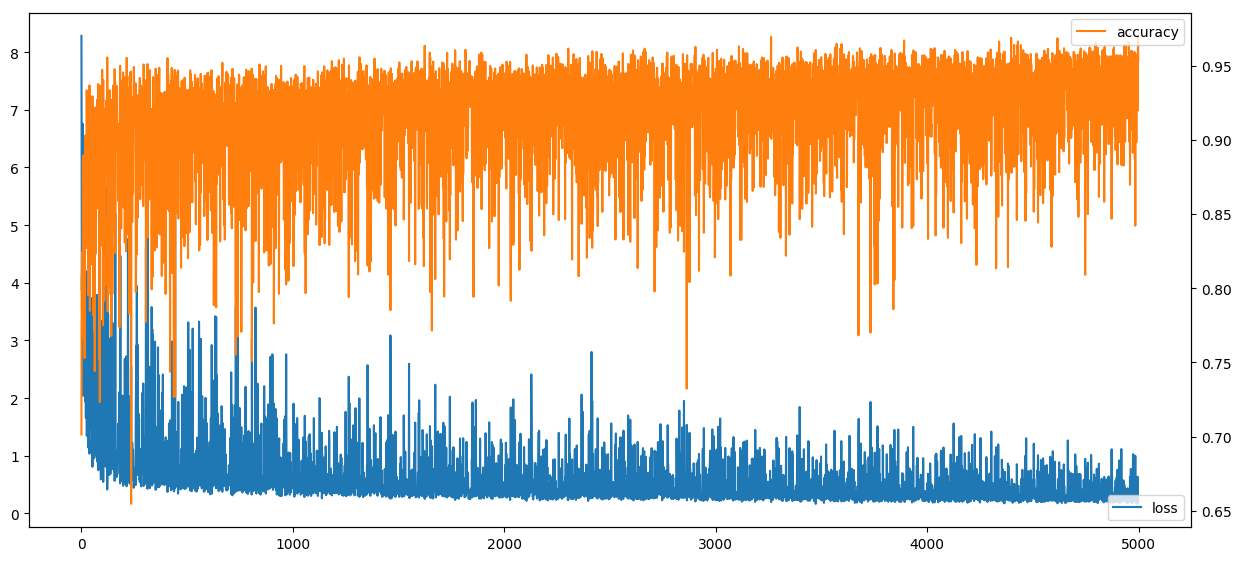

In [22]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()